### Data preprocessing

#### Import the dataset

In [8]:
import numpy as np
import pandas as pd
from pandas import read_csv

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'

data = read_csv(url,header=None)
data.columns = ['age','workclass','fnlwgt','education','education_-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','lessOrBigger_than_50K']
data = data.drop(['fnlwgt','education_-num'], axis=1)
data.loc[data['lessOrBigger_than_50K'] == ' <=50K', 'lessOrBigger_than_50K'] = 0
data.loc[data['lessOrBigger_than_50K'] == ' >50K', 'lessOrBigger_than_50K'] = 1
data.head(5)

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,lessOrBigger_than_50K
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


#### Observe the dataset

In [9]:
print(f'The data shape is {data.shape}')
print('--------------------------------')
print(f'The numbers of NAN value in the dataset are \n{data.isnull().sum()}')
print('--------------------------------')
print(data.describe())

The data shape is (32561, 13)
--------------------------------
The numbers of NAN value in the dataset are 
age                      0
workclass                0
education                0
marital-status           0
occupation               0
relationship             0
race                     0
sex                      0
capital-gain             0
capital-loss             0
hours-per-week           0
native-country           0
lessOrBigger_than_50K    0
dtype: int64
--------------------------------
                age  capital-gain  capital-loss  hours-per-week
count  32561.000000  32561.000000  32561.000000    32561.000000
mean      38.581647   1077.648844     87.303830       40.437456
std       13.640433   7385.292085    402.960219       12.347429
min       17.000000      0.000000      0.000000        1.000000
25%       28.000000      0.000000      0.000000       40.000000
50%       37.000000      0.000000      0.000000       40.000000
75%       48.000000      0.000000      0.000000

In [10]:
for ind in range(data.shape[1]):
    if data.dtypes[ind] != 'int64':
        col_name= data.dtypes.index[ind]
        print(col_name)
        print(data[col_name].value_counts())
        print('--------------------------------------------------------------')

workclass
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64
--------------------------------------------------------------
education
 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64
--------------------------------------------------------------
marital-status
 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married

### Biuld the model

In [11]:
X = data.iloc[:, :11]
y = data.iloc[:, 12].astype('int')

In [12]:
X = pd.get_dummies(X)

#### Build the machine learnig model

In [13]:
from deap import base
from deap import creator
from deap import tools
import random

# define a single objective, maximizing fitness strategy:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
# fill in the with random floats for each type of hyper parameter
toolbox.register("h1", random.uniform, 10, 50)
toolbox.register("h2", random.uniform, 5, 20)
toolbox.register("h3", random.uniform, 20, 50)

toolbox.register("IndividualCreator",tools.initCycle,creator.Individual,
                 (toolbox.h1,toolbox.h2,toolbox.h3),n=1)

In [14]:
def getParams(individual):
    n_est = round(individual[0])
    max_depth = round(individual[1])
    min_samples_leaf = round(individual[2])
    return n_est, max_depth, min_samples_leaf

In [15]:
from sklearn import model_selection, ensemble

kfold = model_selection.KFold(n_splits=2, random_state=42, shuffle=True)

def getAccuracy(individual):
    n_estimators, max_depth, min_samples_leaf = getParams(individual)
    classifier = ensemble.RandomForestClassifier(random_state=42,
                                         n_estimators=n_estimators,
                                         max_depth=max_depth,
                                         min_samples_leaf=min_samples_leaf
                                         )

    cv_results = model_selection.cross_val_score(classifier,
                                                 X,
                                                 y,
                                                 cv=kfold,
                                                 scoring='accuracy', 
                                                 error_score="raise")
    return cv_results.mean()

In [16]:
# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, 
                 toolbox.IndividualCreator)
# fitness calculation
def classificationAccuracy(individual):
    return getAccuracy(individual),

toolbox.register("evaluate", classificationAccuracy)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxUniform, indpb=0.8)
toolbox.register("mutate", tools.mutUniformInt, low=[10, 5, 20], up=[50, 20, 50], indpb=0.1)


In [17]:
from deap import algorithms

# Genetic Algorithm constants:
POPULATION_SIZE = 10
P_CROSSOVER = 0.8  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 10
HALL_OF_FAME_SIZE = 3

# create initial population (generation 0):
population = toolbox.populationCreator(n=POPULATION_SIZE)

# prepare the statistics object:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# perform the Genetic Algorithm flow with hof feature added:
population, logbook = algorithms.eaSimple(population,
                                          toolbox,
                                          cxpb=P_CROSSOVER,
                                          mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS,
                                          stats=stats,
                                          halloffame=hof,
                                          verbose=True)

# print best solution found:
print("- Best solution is: ")
print("params = ", hof.items[0])
print("Accuracy = %1.5f" % hof.items[0].fitness.values[0])

gen	nevals	max     	avg     
0  	10    	0.855502	0.850917
1  	4     	0.855502	0.854381
2  	8     	0.855502	0.855336
3  	8     	0.855625	0.855382
4  	9     	0.857068	0.855695
5  	9     	0.857068	0.855877
6  	8     	0.857068	0.855913
7  	8     	0.857068	0.856184
8  	8     	0.857068	0.856761
9  	8     	0.857068	0.85689 
10 	8     	0.857068	0.857068
- Best solution is: 
params =  [46.64176691256359, 17.797939152421566, 25]
Accuracy = 0.85707


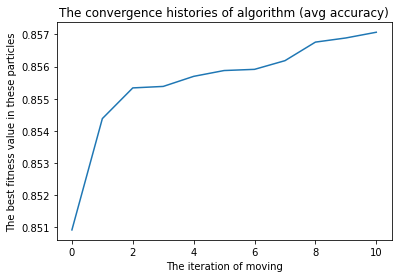

In [18]:
import matplotlib.pyplot as plt

plt.plot([con_row['avg'] for con_row in logbook])
plt.title('The convergence histories of algorithm (avg accuracy)')
plt.xlabel('The iteration of moving')
plt.ylabel('The best fitness value in these particles')
plt.show()

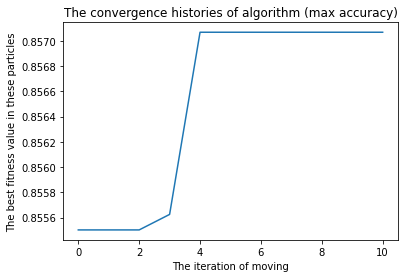

In [19]:
plt.plot([con_row['max'] for con_row in logbook])
plt.title('The convergence histories of algorithm (max accuracy)')
plt.xlabel('The iteration of moving')
plt.ylabel('The best fitness value in these particles')
plt.show()

gen	nevals	max    	avg     
0  	10    	0.85627	0.851583
1  	10    	0.856945	0.853435
2  	9     	0.85756 	0.856006
3  	8     	0.85756 	0.857059
4  	9     	0.85756 	0.856967
5  	8     	0.85756 	0.857179
6  	10    	0.85756 	0.85756 
7  	6     	0.85756 	0.85756 
8  	9     	0.85756 	0.857345
9  	5     	0.85756 	0.85756 
10 	9     	0.85756 	0.85756 
gen	nevals	max     	avg     
0  	10    	0.855901	0.850487
1  	8     	0.855901	0.853813
2  	8     	0.855901	0.854734
3  	9     	0.855655	0.854909
4  	10    	0.855932	0.855401
5  	10    	0.855963	0.855702
6  	8     	0.855963	0.855874
7  	9     	0.856362	0.856018
8  	9     	0.856362	0.856058
9  	9     	0.856362	0.855901
10 	8     	0.856362	0.8563  
gen	nevals	max     	avg     
0  	10    	0.855932	0.851979
1  	9     	0.855932	0.854627
2  	9     	0.855932	0.855652
3  	8     	0.855993	0.855938
4  	10    	0.855993	0.855874
5  	10    	0.855993	0.855956
6  	10    	0.855993	0.855993
7  	10    	0.855993	0.855993
8  	7     	0.855993	0.854237
9  	8     	0.855

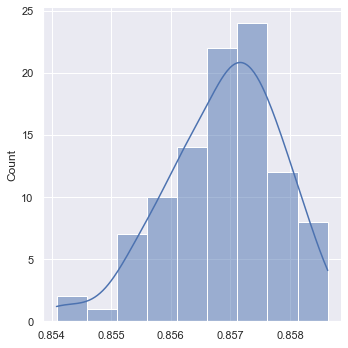

In [24]:
import seaborn as sns
GA_record = []

for _ in range(100):

    # Genetic Algorithm constants:
    POPULATION_SIZE = 10
    P_CROSSOVER = 0.8  # probability for crossover
    P_MUTATION = 0.1   # probability for mutating an individual
    MAX_GENERATIONS = 10
    HALL_OF_FAME_SIZE = 3

    # create initial population (generation 0):
    population = toolbox.populationCreator(n=POPULATION_SIZE)

    # prepare the statistics object:
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    stats.register("avg", np.mean)

    # define the hall-of-fame object:
    hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

    # perform the Genetic Algorithm flow with hof feature added:
    population, logbook = algorithms.eaSimple(population,
                                            toolbox,
                                            cxpb=P_CROSSOVER,
                                            mutpb=P_MUTATION,
                                            ngen=MAX_GENERATIONS,
                                            stats=stats,
                                            halloffame=hof,
                                            verbose=True)
    GA_record.append(logbook[-1]['avg'])



sns.set()
sns.displot(GA_record, kde=True)

In [25]:
print('done')

done


### Grid search to compare the GA result

In [42]:
result_rec = []
iter_num = 25

for n_estimators in np.linspace(10, 50, num=iter_num):
    for max_depth in np.linspace(5, 20, num=iter_num):
        for min_samples_leaf in np.linspace(20, 50, num=iter_num):
            classifier = ensemble.RandomForestClassifier(random_state=42,
                                                    n_estimators=round(n_estimators),
                                                    max_depth=round(max_depth),
                                                    min_samples_leaf=round(min_samples_leaf)
                                                    )

            cv_results = model_selection.cross_val_score(classifier,
                                                            X,
                                                            y,
                                                            cv=kfold,
                                                            scoring='accuracy', 
                                                            error_score="raise")

            result_rec.append(cv_results.mean())

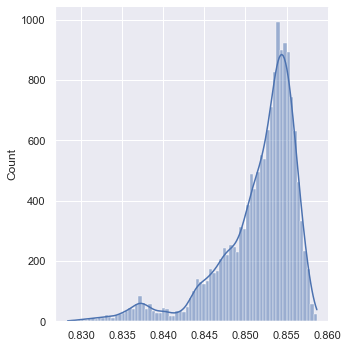

In [43]:
import seaborn as sns

sns.set()
sns.displot(result_rec, kde=True)